In [1]:
from matplotlib import pyplot as plt 
import numpy as np 
from skimage import morphology
from skimage import segmentation
from joblib import Parallel, delayed
import multiprocessing
import skimage

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140]) 



In [36]:
def create_mask(im): 
    im_col = plt.imread(im)
    print(len(im_col))
    print(len(im_col[0]))
    im_gray = rgb2gray(im_col)
    thres = skimage.filters.threshold_otsu(im_gray)
    mask = im_gray < thres
    struct_el = morphology.disk(5)
    opened = morphology.opening(mask,struct_el)
    tmp_mask = skimage.segmentation.clear_border(opened)
    tmp_label = skimage.measure.label(tmp_mask)
    tmp_label = tmp_label * tmp_mask
    for i in tmp_label.flatten():
        if i not in tmp_list:
            tmp_list.append(i)
    print(len(tmp_list))
    print(tmp_list)
    
    col_mask = im_gray * tmp_label 
    tmp = segmentation.slic(col_mask, n_segments = len(tmp_list)+1, sigma = 1, compactness = 10, start_label = 1)
    
    return col_mask, tmp


In [37]:
im , seg= create_mask("../data/example_image/ISIC_0007235.jpg")


2848
4288
10353
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 130.75169999999997, 129.7518, 129.6378, 128.6379, 128.7519, 127.638, 130.63769999999997, 130.97969999999998, 129.9798, 131.6376, 130.2356, 131.23549999999997, 129.6809, 128.9799, 127.98, 129.9906, 127.75200000000001, 128.68099999999998, 126.98009999999998, 128.7627, 127.7628, 129.0077, 129.2357, 126.75209999999998, 129.04000000000002, 128.0401, 127.62099999999998, 127.9091, 130.0076, 125.7522, 126.04029999999999, 129.94750000000002, 128.9476, 127.23589999999999, 124.75229999999999, 128.2188, 128.1371, 128.23579999999998, 126.23599999999999, 126.7629, 129.21869999999998, 128.62089999999998, 128.4252, 129.7626, 128.99069999999998, 127.9908, 126.9909, 129.137, 130.2186, 130.1369, 130.6207, 129.6208, 129.84879999999998, 129.66389999999998, 130.84869999999998, 192.4474, 215.727, 206.446, 189.8714, 175.87279999999998, 176.3288, 181.7304, 193.7292, 222.18239999999997, 248.15819999999997, 255.24539999999996, 235.2474, 220.4446,

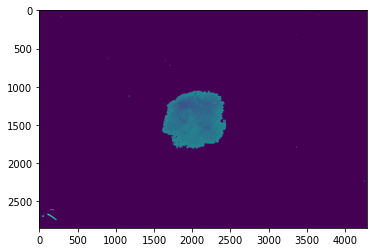

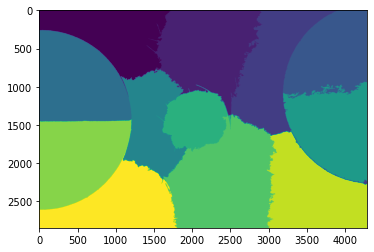

In [31]:
plt.imshow(im)
plt.show()
plt.imshow(seg)
plt.show()


In [13]:
tmp_mask = skimage.segmentation.clear_border(mask)
tmp_label = skimage.measure.label(tmp_mask)
tmp_list = []
tmp_label = tmp_label * tmp_mask 
# for i in tmp_label.flatten():
#     if i not in tmp_list:
#         tmp_list.append(i)


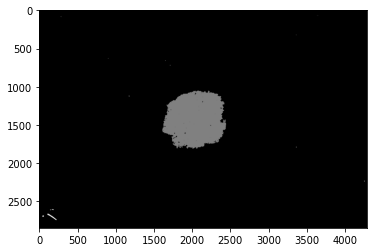

In [14]:
plt.imshow(tmp_label, cmap='gray')


In [24]:
tmp_list = []
tmp_dict = {}
for i in range(1,251): 
    tmp_index = np.argwhere(tmp == i)
    # tmp_array = np.where(tmp == i)
    tmp_index = [(k[0],k[1]) for k in tmp_index]
    tmp_dict[str(i)] = {"Coordinates": tmp_index,
                "Values": [mask[k[0],k[1]] for k in tmp_index],
                "Sum": 0,
                "Result": 0}
    tmp_dict[str(i)]['Sum'] = sum(tmp_dict[str(i)]['Values'])
    if tmp_dict[str(i)]["Sum"] > len(tmp_dict[str(i)]["Values"])/2:
        tmp_dict[str(i)]["Result"] = 1





In [25]:
cluster_dict = {}
for i in tmp_dict.keys(): 
    tmp_dict[i]["Edges"] = []
    if tmp_dict[i]["Result"] == 1: 
        cluster_dict[i] = tmp_dict[i]
for i in tmp_dict.keys():
    tmp_dict[i]['min_x'] = 4500
    tmp_dict[i]['max_x'] = 0 
    tmp_dict[i]['min_y'] = 4500
    tmp_dict[i]['max_y'] = 0  
    for j in tmp_dict[i]['Coordinates']: 
        if j[0] > tmp_dict[i]['max_x']: 
            tmp_dict[i]['max_x'] = j[0]
        if j[0] < tmp_dict[i]['min_x']:
            tmp_dict[i]['min_x'] = j[0]
        if j[1] > tmp_dict[i]['max_y']: 
            tmp_dict[i]['max_y'] = j[1]
        if j[1] < tmp_dict[i]['min_y']: 
            tmp_dict[i]['min_y'] = j[1]
# for i in tmp_dict: 
#     print(f"Min X = {tmp_dict[i]['min_x']} Max X = {tmp_dict[i]['max_x']} Min Y = {tmp_dict[i]['min_y']} Max Y = {tmp_dict[i]['max_y']} - Values {len(tmp_dict[i]['Coordinates'])}")

In [29]:
print(tmp_dict['15']['max_x'])
print(tmp_dict['15']['min_x'])
print(tmp_dict['15']['max_y'])
print(tmp_dict['15']['min_y'])

2074
0
4161
3182


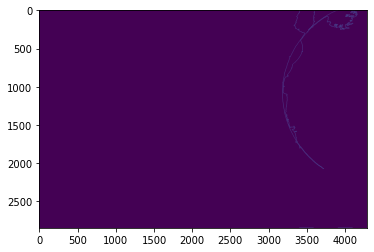

In [31]:
tmp_array = np.zeros((2848,4288))
for i in tmp_dict['15']['Coordinates']: 
    tmp_array[i[0]][i[1]] = 1 

tmp_enlarged = np.roll(tmp_array, 1, axis = 1) + np.roll(tmp_array, -1, axis = 1) + np.roll(tmp_array, -1, axis = 0) + np.roll(tmp_array, 1, axis = 0)
tmp_coord = np.argwhere(tmp_enlarged > 0)
tmp_enlarged = np.zeros((2848,4288))
for i in tmp_coord: 
    tmp_enlarged[i[0]][i[1]] = 1 

edge_mask = tmp_enlarged - tmp_array 
plt.imshow(edge_mask)

# tmp_right = np.roll(tmp_array, 1, axis = 1)
# tmp_left =  np.roll(tmp_array, -1, axis = 1)
# tmp_up = np.roll(tmp_array, -1, axis = 0)
# tmp_down = np.roll(tmp_array, 1, axis = 0)


In [26]:
def processInput(coordinates, coordinate):
    edge_list = []
    tmp_edge_list = [(k[0],k[1]) for k in coordinates if k[0] ]
    for k in coordinates: 
        if k[0] >= coordinate[0] + 2 or k[0] <= coordinate[0] -2 or k[1] >= coordinate[1] + 2 or k[1] <= coordinate[1] -2:
            continue 
        if k[0] in (coordinate[0]-1,coordinate[0]+1) and k[1] == coordinate[1]: 
            edge_list.append(k)
        elif k[1] in (coordinate[1]-1,coordinate[1]+1) and k[0] == coordinate[0]:
            edge_list.append(k) 
        if len(edge_list) == 4: 
            break 
    if len(edge_list) < 4: 
        return (coordinate[0],coordinate[1])
    else: 
        return 
    
num_cores = multiprocessing.cpu_count()
for i in cluster_dict.keys(): 
    print(i)
    edges = Parallel(n_jobs=num_cores)(delayed(processInput)(cluster_dict[i]["Coordinates"], j) for j in cluster_dict[i]["Coordinates"])
    # print(edges)
    edges = [i for i in edges if i != None]
    # print(edges[0])
    cluster_dict[i]["Edges"] = edges
    print(f"{i} - {len(cluster_dict[i]['Edges'])} - {len(cluster_dict[i]['Coordinates'])}")
    # for j in tmp_dict[i]["Coordinates"]: 






# results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)


15


KeyboardInterrupt: 

In [29]:
# print(cluster_dict.keys())

dict_keys(['185', '192', '194', '199', '204', '222', '230', '241', '242', '245', '404', '405', '406', '408', '413', '423', '428', '429', '430', '431', '434', '436', '438', '442', '446', '453', '454', '456', '457', '459', '460', '461', '462', '467', '471', '474', '477'])


In [33]:
cluster_list = []
checked = []
for i in cluster_dict.keys(): 
    checked.append(i)
    for j in cluster_dict.keys(): 
        if j in checked: 
            continue 
        # print(f"{i}, {j}")
        clustered = False 
        for k in cluster_dict[i]["Edges"]: 
            for l in cluster_dict[j]["Edges"]:
                if k[0] == l[0] and k[1] in (l[1]-1, l[1]+1):
                    cluster_list.append((i,j))
                    clustered = True 
                    break 
                elif k[1] == l[1] and k[0] in (l[0]-1, l[0]+1):
                    cluster_list.append((i,j))
                    clustered = True 
                    break 
                    
            if clustered: 
                break 
            


185, 192
185, 194
185, 199
185, 204
185, 222
185, 230
185, 241
185, 242
185, 245
185, 404
185, 405
185, 406
185, 408
185, 413
185, 423
185, 428
185, 429
185, 430
185, 431
185, 434
185, 436
185, 438
185, 442
185, 446
185, 453
185, 454
185, 456
185, 457
185, 459
185, 460
185, 461
185, 462
185, 467
185, 471
185, 474
185, 477
192, 194
192, 199
192, 204
192, 222
192, 230
192, 241
192, 242
192, 245
192, 404
192, 405
192, 406
192, 408
192, 413
192, 423
192, 428
192, 429
192, 430
192, 431
192, 434
192, 436
192, 438
192, 442
192, 446
192, 453
192, 454
192, 456
192, 457
192, 459
192, 460
192, 461
192, 462
192, 467
192, 471
192, 474
192, 477
194, 199
194, 204
194, 222
194, 230
194, 241
194, 242
194, 245
194, 404
194, 405
194, 406
194, 408
194, 413
194, 423
194, 428
194, 429
194, 430
194, 431
194, 434
194, 436
194, 438
194, 442
194, 446
194, 453
194, 454
194, 456
194, 457
194, 459
194, 460
194, 461
194, 462
194, 467
194, 471
194, 474
194, 477
199, 204
199, 222
199, 230
199, 241
199, 242
199, 245
1

In [52]:
tmp_list_two = []
for i in cluster_list: 
    if tmp_list_two == []: 
            tmp_list_two.append([i[0],i[1]]) 
            continue 
    added = True 
    for j in tmp_list_two:
        
        if i[0] in j and i[1] in j: 
            added = False
        elif i[0] in j: 
            j.append(i[1])
            added = False 
        elif i[1] in j:
            j.append(i[0])
            added = False
        else: 
            pass 
    if added: 
        tmp_list_two.append([i[0],i[1]])
clusters = {}
for i in range(len(tmp_list_two)):
    clusters[str(i)] = {
        'Coordinates': [], 
        'Edges': [],
        'Temporary': []
    }
    for j in tmp_list_two[i]: 
        clusters[str(i)]["Coordinates"].extend(cluster_dict[j]['Coordinates'])
        clusters[str(i)]["Temporary"].extend(cluster_dict[j]['Edges'])

        

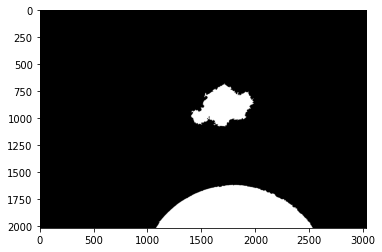

In [117]:
mask = np.zeros((2848,4288))
2848
4288
for j in clusters: 
    for i in clusters[j]['Coordinates']: 
        mask[i[0]][i[1]] = 1 

plt.imshow(mask, cmap='gray')


In [66]:
print(clusters['0']["Temporary"][0])

(677, 1705)


In [82]:
for i in clusters: 
    x_list = {}
    y_list = {}
    for k in clusters[i]["Temporary"]: 
        if k[0] in x_list.keys(): 
            x_list[k[0]].append(k[1])
        else: 
            x_list[k[0]] = [k[1]]
        if k[1] in y_list.keys(): 
            y_list[k[1]].append(k[0])
        else:
            y_list[k[1]] = [k[0]]
    # tmp_edges = []
    # for j in x_list:
    #     tmp_edges.append((j,max(x_list[j])))
    #     tmp_edges.append((j,min(x_list[j])))
    # for j in y_list:
    #     tmp_edges.append((max(y_list[j]),j))
    #     tmp_edges.append((min(y_list[j]),j))
    clusters[i]["x_list"] = x_list
    clusters[i]["y_list"] = y_list



In [106]:
print(clusters['0']['x_list'][754])

[1601, 1601, 1613, 1897, 1898]


In [108]:
xs = []
ys = []


for i in clusters['0']["x_list"]: 
    print(i)
    continuous = []
    checked = []
    tmp_x_list = set(clusters['0']["x_list"][i])
    tmp_x_list = sorted(list(tmp_x_list))
    # print(tmp_x_list)
    if len(tmp_x_list) == 1: 
        xs.append((i,tmp_x_list[0]))
        continue 
    k = 1
    for j in range(len(tmp_x_list)):
        # print(j)
        # print(checked)
        # print(continuous)
        if j in checked: 
            continue 
        checked.append(j)
        continuous.append(tmp_x_list[j])
        if len(tmp_x_list) <= j+k:
            break 

        while tmp_x_list[j+k] == tmp_x_list[j] + k: 
            # print(j)
            checked.append(j+k)
            k += 1 
            if j + k >= len(tmp_x_list): 
                break 
        continuous.append(tmp_x_list[j+k-1])
        
    for j in continuous: 
        xs.append((i,j))
for i in clusters['0']["y_list"]: 
    print(i)
    continuous = []
    checked = []
    tmp_y_list = set(clusters['0']["y_list"][i])
    tmp_y_list = sorted(list(tmp_y_list))
    # print(tmp_x_list)
    if len(tmp_y_list) == 1: 
        xs.append((tmp_y_list[0],i))
        continue 
    k = 1
    for j in range(len(tmp_y_list)):
        # print(j)
        # print(checked)
        # print(continuous)
        if j in checked: 
            continue 
        checked.append(j)
        continuous.append(tmp_y_list[j])
        if len(tmp_y_list) <= j+k:
            break 

        while tmp_y_list[j+k] == tmp_y_list[j] + k: 
            # print(j)
            checked.append(j+k)
            k += 1 
            if j + k >= len(tmp_y_list): 
                break 
        continuous.append(tmp_y_list[j+k-1])
        
    for j in continuous: 
        ys.append((i,j))


677
707
710
730
735
755
761
789
790
795
801
802
803
753
754
756
757
758
759
760
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
791
792
793
794
796
797
798
799
800
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
749
750
751
752
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993


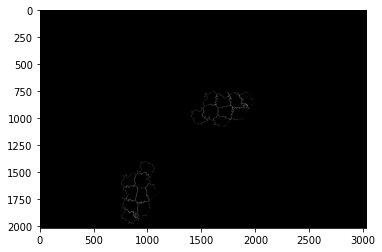

In [57]:
# def processInput(coordinates, coordinate):
#     edge_list = []
#     for k in coordinates: 
#         if k[0] >= coordinate[0] + 2 or k[0] <= coordinate[0] -2 or k[1] >= coordinate[1] + 2 or k[1] <= coordinate[1] -2:
#             continue 
#         if k[0] in (coordinate[0]-1,coordinate[0]+1) and k[1] == coordinate[1]: 
#             edge_list.append(k)
#         elif k[1] in (coordinate[1]-1,coordinate[1]+1) and k[0] == coordinate[0]:
#             edge_list.append(k) 
#         if len(edge_list) == 4: 
#             break 
#     if len(edge_list) < 4: 
#         return coordinate 
#     else: 
#         return 
    
def processInput(coordinates, coordinate):
    edge_list = [(k[0],k[1]) for k in coordinates if k[0] in (coordinate[0]-1,coordinate[0]+1) and k[1] == coordinate[1]]
    edge_list.extend([(k[0],k[1]) for k in coordinates if k[1] in (coordinate[1]-1,coordinate[1]+1) and k[0] == coordinate[0]])
    # for k in coordinates: 
    #     if k[0] >= coordinate[0] + 2 or k[0] <= coordinate[0] -2 or k[1] >= coordinate[1] + 2 or k[1] <= coordinate[1] -2:
    #         continue 
    #     if k[0] in (coordinate[0]-1,coordinate[0]+1) and k[1] == coordinate[1]: 
    #         edge_list.append(k)
    #     elif k[1] in (coordinate[1]-1,coordinate[1]+1) and k[0] == coordinate[0]:
    #         edge_list.append(k) 
    #     if len(edge_list) == 4: 
    #         break 
    if len(edge_list) < 4: 
        return coordinate 
    else: 
        return 


num_cores = multiprocessing.cpu_count()
for i in clusters.keys(): 
    print(i)
    edges = Parallel(n_jobs=num_cores)(delayed(processInput)(clusters[i]["Coordinates"], j) for j in clusters[i]["Temporary"])
    edges = [i for i in edges if i != None]
    # print(edges[0])
    clusters[i]["Edges"] = edges
    print(f"{i} - {len(clusters[i]['Edges'])} - {len(clusters[i]['Coordinates'])}")
    # for j in tmp_dict[i]["Coordinates"]: 
    


0


KeyboardInterrupt: 

In [ ]:
def processInput(coordinates, coordinate):
    edge_list = [(k[0],k[1]) for k in coordinates if k[0] in (coordinate[0]-1,coordinate[0]+1) and k[1] == coordinate[1]]
    edge_list.extend([(k[0],k[1]) for k in coordinates if k[1] in (coordinate[1]-1,coordinate[1]+1) and k[0] == coordinate[0])
    # for k in coordinates: 
    #     if k[0] >= coordinate[0] + 2 or k[0] <= coordinate[0] -2 or k[1] >= coordinate[1] + 2 or k[1] <= coordinate[1] -2:
    #         continue 
    #     if k[0] in (coordinate[0]-1,coordinate[0]+1) and k[1] == coordinate[1]: 
    #         edge_list.append(k)
    #     elif k[1] in (coordinate[1]-1,coordinate[1]+1) and k[0] == coordinate[0]:
    #         edge_list.append(k) 
    #     if len(edge_list) == 4: 
    #         break 
    if len(edge_list) < 4: 
        return coordinate 
    else: 
        return 